In [26]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
#             np.random.shuffle(this_xs)
            this_xs = this_xs.reindex(np.random.permutation(this_xs.index))


        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

#     xs = np.concatenate(xs)
#     ys = np.concatenate(ys)
    xs = pd.concat(xs)
    ys = pd.Series(data=np.concatenate(ys),name='target')

    return xs,ys

In [3]:
conn = sqlite3.connect('/Users/aaronlevi/Documents/sql_db/pick-a-tune.db')
cur = conn.cursor()

# cur.close()
# conn.close()

In [4]:
allFeatures = pd.read_sql_query("SELECT * FROM features", conn)
labels = pd.read_sql_query("SELECT label FROM basic_info", conn)

# allFeatures = allFeatures.reset_index(drop=True)
# allFeatures.drop('index', axis=1, inplace=True)

# labels = labels.reset_index(drop=True)

allFeatures = allFeatures.iloc[57:1329].reset_index(drop=True)
allFeatures.drop('index', axis=1, inplace=True)

labels = labels.iloc[57:1329].reset_index(drop=True)

In [5]:
dummyLabel=pd.get_dummies(labels)
dummyLabel.head()

,Label_advanced,Label_intermediate,Label_novice
0,1,0,0
1,0,1,0
2,0,0,1
3,1,0,0
4,0,0,1


In [73]:
# making a few df's for ease of plotting... kinda clunky
featuresWithLabels = pd.concat([allFeatures, dummyLabel], axis=1, sort=False)
featuresWithLabels.dropna(axis=0, how='any', inplace=True)

featuresNov = pd.concat([allFeatures, dummyLabel['Label_novice']], axis=1, sort=False)
featuresNov.dropna(axis=0, how='any', inplace=True)

featuresInter = pd.concat([allFeatures, dummyLabel['Label_intermediate']], axis=1, sort=False)
featuresInter.dropna(axis=0, how='any', inplace=True)

featuresAdv = pd.concat([allFeatures, dummyLabel['Label_advanced']], axis=1, sort=False)
featuresAdv.dropna(axis=0, how='any', inplace=True)
featuresAdv.head()

,tempo,duration_m,time_signature,energy,n_unique_chords,n_difficult_chords,chord_per_min,Label_advanced
0,123.015,1.786167,4.0,0.245,15,14,23.514043,1
1,92.640,3.737333,4.0,0.139,12,0,21.673207,0
2,131.712,12.112833,4.0,0.260,8,4,18.823011,0
3,129.937,4.476100,4.0,0.364,14,8,21.447242,1
4,83.720,2.723117,4.0,0.307,13,4,23.135256,0


In [8]:
X = featuresAdv.dropna(axis=0, how='any')
X.reset_index(drop=True)

y = X['Label_advanced']
X.drop('Label_advanced', axis=1, inplace=True)

In [50]:
Xs, ys = balanced_subsample(X,y)
sum(ys) / len(ys)

0.5

In [51]:
scaler = StandardScaler()
scaler.fit(Xs)
X_scale = scaler.transform(Xs)

X_train, X_test, y_train, y_test = train_test_split(X_scale, ys, test_size=0.2, random_state=10)

lr_model_adv = LogisticRegression()
lr_model_adv.fit(X_train, y_train) 

LogisticRegression()

In [52]:
adv_predictions = lr_model_adv.predict(X_test)
adv_true = y_test

print(confusion_matrix(y_test, adv_predictions))
print(classification_report(y_test, adv_predictions))

[[90  5]
 [26 60]]
              precision    recall  f1-score   support

         0.0       0.78      0.95      0.85        95
         1.0       0.92      0.70      0.79        86

    accuracy                           0.83       181
   macro avg       0.85      0.82      0.82       181
weighted avg       0.85      0.83      0.83       181



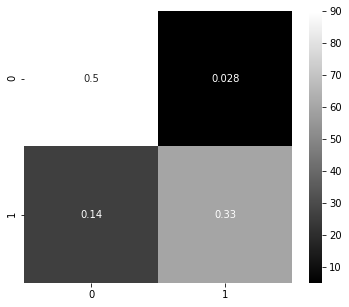

In [55]:
f = plt.figure(figsize=(6, 5))

sns.heatmap(confusion_matrix(y_test, adv_predictions), cmap='gray', annot=[[90/181, 5/181],[26/181,60/181]])
f.savefig("figures/isAdv_confusion.png", bbox_inches='tight', dpi=600)

In [57]:
pd.DataFrame(lr_model_adv.coef_, columns=X.columns)

,tempo,duration_m,time_signature,energy,n_unique_chords,n_difficult_chords,chord_per_min
0,0.133508,0.20698,-0.115582,0.086623,1.015371,1.717761,0.142571


In [74]:
X = featuresNov.dropna(axis=0, how='any')
X.reset_index(drop=True)

y = X['Label_novice']
X.drop('Label_novice', axis=1, inplace=True)

In [75]:
Xs, ys = balanced_subsample(X,y)

scaler.fit(Xs)
X_scale = scaler.transform(Xs)

X_train, X_test, y_train, y_test = train_test_split(X_scale, ys, test_size=0.2, random_state=10)

lr_model_nov = LogisticRegression()
lr_model_nov.fit(X_train, y_train) 

LogisticRegression()

In [76]:
nov_predictions = lr_model_nov.predict(X_test)
nov_true = y_test

print(confusion_matrix(y_test, nov_predictions))
print(classification_report(y_test, nov_predictions))

[[43 34]
 [11 70]]
              precision    recall  f1-score   support

         0.0       0.80      0.56      0.66        77
         1.0       0.67      0.86      0.76        81

    accuracy                           0.72       158
   macro avg       0.73      0.71      0.71       158
weighted avg       0.73      0.72      0.71       158



In [80]:
pd.DataFrame(lr_model_nov.coef_, columns=X.columns)

,tempo,duration_m,time_signature,energy,n_unique_chords,n_difficult_chords,chord_per_min
0,-0.055554,-0.011113,-0.025625,-0.052201,-1.4074,-0.752094,-0.220538


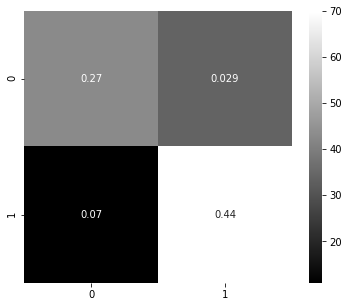

In [79]:
f = plt.figure(figsize=(6, 5))

sns.heatmap(confusion_matrix(y_test, nov_predictions), cmap='gray', annot=[[43/158, 34/1158],[11/158,70/158]])
# f.savefig("figures/isAdv_confusion.png", bbox_inches='tight', dpi=600)

In [66]:
X = featuresInter.dropna(axis=0, how='any')
X.reset_index(drop=True)

y = X['Label_intermediate']
X.drop('Label_intermediate', axis=1, inplace=True)

In [69]:
Xs, ys = balanced_subsample(X,y)

scaler.fit(Xs)
X_scale = scaler.transform(Xs)

X_train, X_test, y_train, y_test = train_test_split(X_scale, ys, test_size=0.2, random_state=10)

lr_model_int = LogisticRegression()
lr_model_int.fit(X_train, y_train) 

LogisticRegression()

In [70]:
int_predictions = lr_model_int.predict(X_test)
int_true = y_test

print(confusion_matrix(y_test, int_predictions))
print(classification_report(y_test, int_predictions))

[[37 44]
 [21 68]]
              precision    recall  f1-score   support

         0.0       0.64      0.46      0.53        81
         1.0       0.61      0.76      0.68        89

    accuracy                           0.62       170
   macro avg       0.62      0.61      0.60       170
weighted avg       0.62      0.62      0.61       170



In [81]:
pd.DataFrame(lr_model_int.coef_, columns=X.columns)

,tempo,duration_m,time_signature,energy,n_unique_chords,n_difficult_chords,chord_per_min
0,-0.044466,-0.195794,0.070018,-0.036864,0.435949,-1.134606,-0.077354
